In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import het_arch

In [2]:
datos_cartera=pd.read_csv('Datos/Transformados/cartera.csv', index_col=[0], parse_dates=[0])
datos_cartera.head()

,AAPL,CAT,MSFT
fecha,,,
2018-06-07,48.37500,156.289993,100.879997
2018-06-08,47.87750,155.320007,101.629997
2018-06-11,47.79000,156.350000,101.050003
2018-06-12,48.08000,157.485000,101.309998
2018-06-13,47.66625,154.700000,100.849998


### AAPL

Text(0.5, 1.0, 'Serie temporal de AAPL')

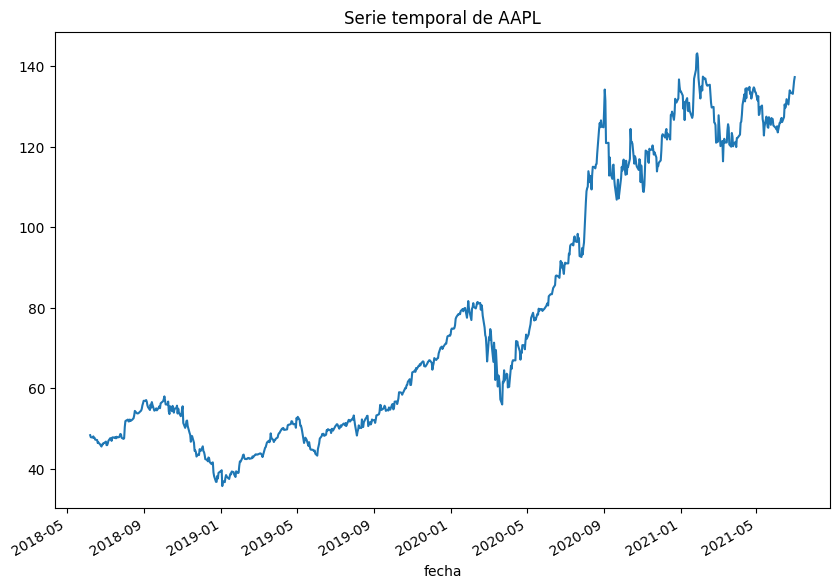

In [3]:
datos_cartera['AAPL'].plot(figsize=(10,7))
plt.title('Serie temporal de AAPL')

In [4]:
datos_cartera['AAPL'].isna().sum()

np.int64(0)

In [5]:
datos_cartera['AAPL'].dtype

dtype('float64')

In [6]:
datos_cartera['AAPL'].resample('Y').count()

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\825100696.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['AAPL'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: AAPL, dtype: int64

ESTACIONALIDAD

Text(0.5, 1.0, 'Autocorrelación ACF de AAPL')

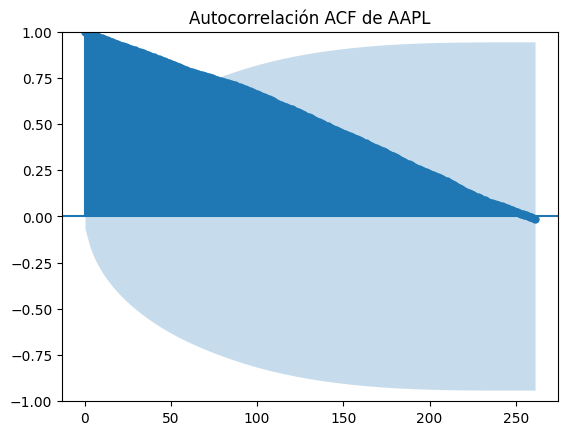

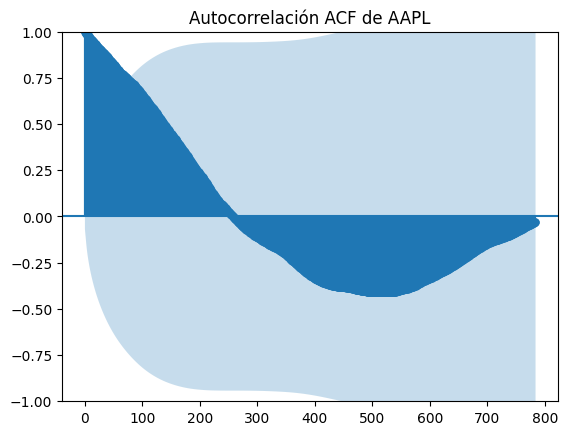

In [7]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['AAPL'], lags=261);
plt.title('Autocorrelación ACF de AAPL')
tsaplots.plot_acf(datos_cartera['AAPL'], lags=(261*3));
plt.title('Autocorrelación ACF de AAPL')

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

<Axes: xlabel='fecha'>

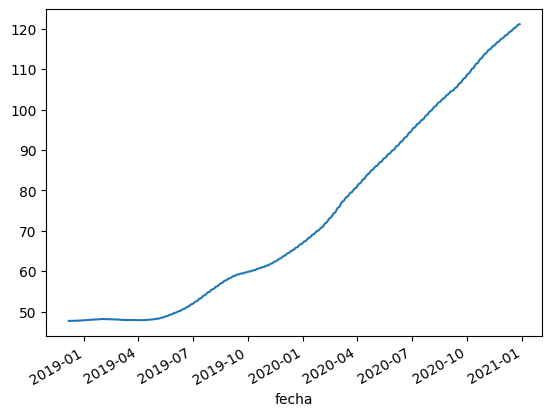

In [8]:
decomposicion_aapl=seasonal_decompose(datos_cartera['AAPL'], model='multiplicative', period=261)
trend=decomposicion_aapl.trend
trend.dropna(inplace=True)
trend.plot()

In [9]:
datos_cartera['residuo_AAPL']=datos_cartera['AAPL'].diff()

In [10]:
def test_estacionario(residuo):

    residuo=residuo.dropna()
    adf_test = adfuller(residuo, autolag='AIC')
    p_adf = adf_test[1]

    kpss_test = kpss(residuo, nlags="auto")
    p_kpss = kpss_test[1]

    arch_test = het_arch(residuo)
    p_arch = arch_test[1]

    if p_adf < 0.05 and p_kpss > 0.05:
        estacionario = "La serie es ESTACIONARIA"
    else:
        estacionario = "La serie NO es estacionaria"

    if p_arch < 0.05:
        heterocedasticidad = "Existe HETEROCEDASTICIDAD (varianza no constante)"
    else:
        heterocedasticidad = "No hay heterocedasticidad (varianza constante)"

    resultados = {
        'ADF_pvalue': p_adf,
        'KPSS_pvalue': p_kpss,
        'ARCH_pvalue': p_arch,
        'Conclusión_estacionariedad': estacionario,
        'Conclusión_heterocedasticidad': heterocedasticidad
    }
    
    return resultados

In [11]:
test_aapl=test_estacionario(datos_cartera['residuo_AAPL'])
test_aapl

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': 0.0,
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(2.366462891192108e-21),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

<Axes: xlabel='fecha'>

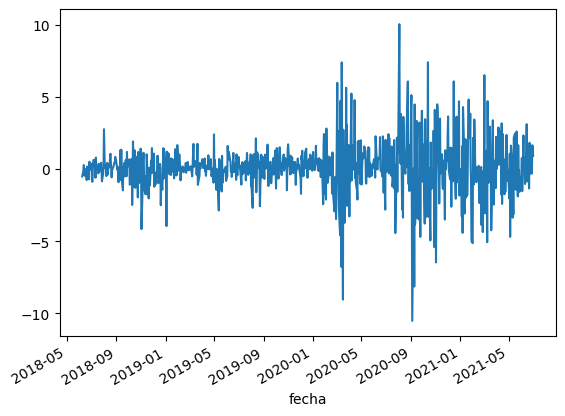

In [12]:
datos_cartera['residuo_AAPL'].plot()

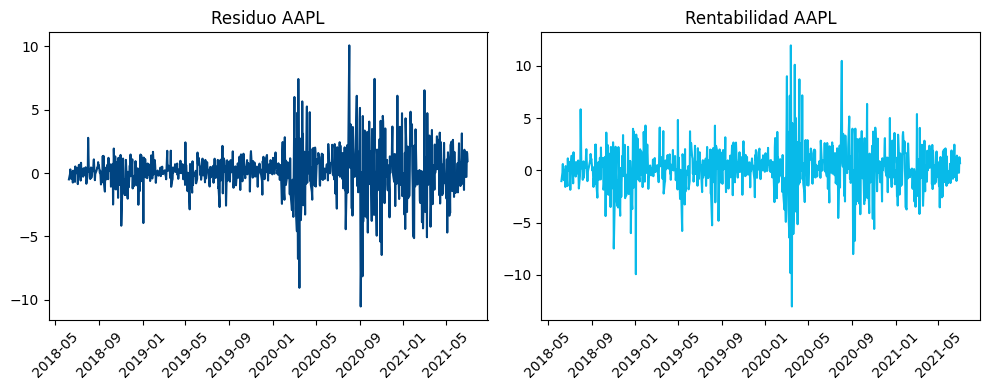

In [13]:
datos_cartera['rent_apple'] = 100*datos_cartera['AAPL'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_AAPL'], color='#004481')
axes[0].set_title("Residuo AAPL")
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(datos_cartera['rent_apple'], color='#08BAE9')
axes[1].set_title("Rentabilidad AAPL")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

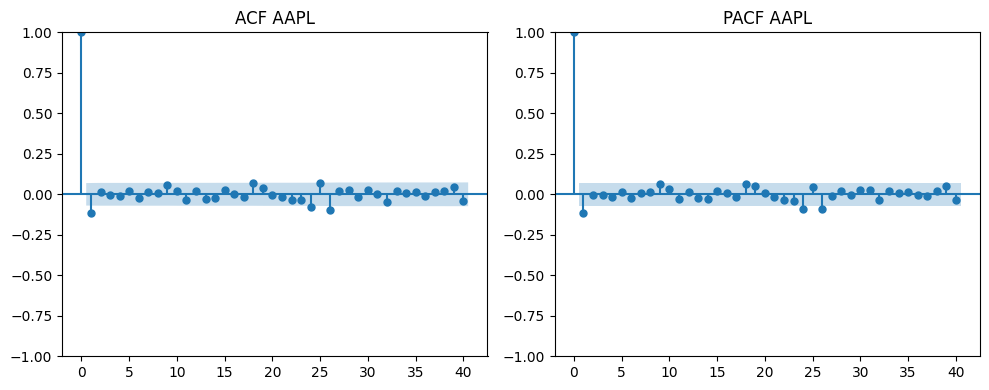

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_AAPL'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF AAPL")

plot_pacf(datos_cartera['residuo_AAPL'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF AAPL")

plt.tight_layout()
plt.show()


In [15]:
from arch import arch_model
garch11 = arch_model(datos_cartera['residuo_AAPL'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_AAPL'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 3423.5212246313235
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2591997.5011681276
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1716.8194529364737
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1387.009767476723
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1382.0952235006848
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1415.3835628081463
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1350.5889670449237
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1350.6628134530217
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1350.5600700059188
Iteration:     10,   Func. Count:     71,   Neg. LLF: 1350.559951011036
Iteration:     11,   Func. Count:     77,   Neg. LLF: 1350.5599494232617
Iteration:     12,   Func. Count:     82,   Neg. LLF: 1350.5599488409916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1350.5599494232617
            Itera

In [16]:

import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)


      lb_stat  lb_pvalue
10   9.035065   0.528779
20  19.865538   0.466369
(np.float64(14.381842951008283), np.float64(0.15627609910185677), 1.4444875597093771, 0.1561197922508687)
alpha+beta = 0.9498146459869452


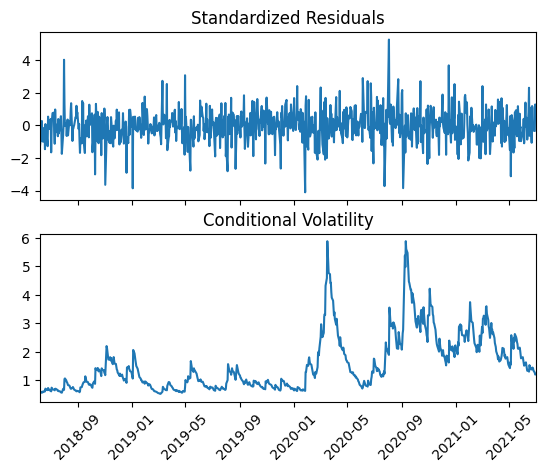

In [17]:
res11.plot()
plt.xticks(rotation=45)
plt.show()

PREDICCIÓN DE LA VOLATILIDAD

In [18]:
start_loc = 0
end_loc = np.where(datos_cartera.index >= '2021-01-01')[0].min()

print(f"Longitud del índice: {len(datos_cartera.index)}")
print(f"start_loc = {start_loc}, end_loc = {end_loc}")


Longitud del índice: 797
start_loc = 0, end_loc = 670


In [19]:
print("Tamaño total de datos:", len(datos_cartera))
print("start_loc:", start_loc)
print("end_loc:", end_loc)

Tamaño total de datos: 797
start_loc: 0
end_loc: 670


In [20]:
forecasts = {}
for i in range(70):
    res = garch11.fit( first_obs=datos_cartera.index[start_loc], last_obs=datos_cartera.index[i + end_loc], disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_expand = pd.DataFrame(forecasts).T


 Done!


In [21]:
forecasts = {}
for i in range(70):
    res = garch11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed = pd.DataFrame(forecasts).T

 Done!


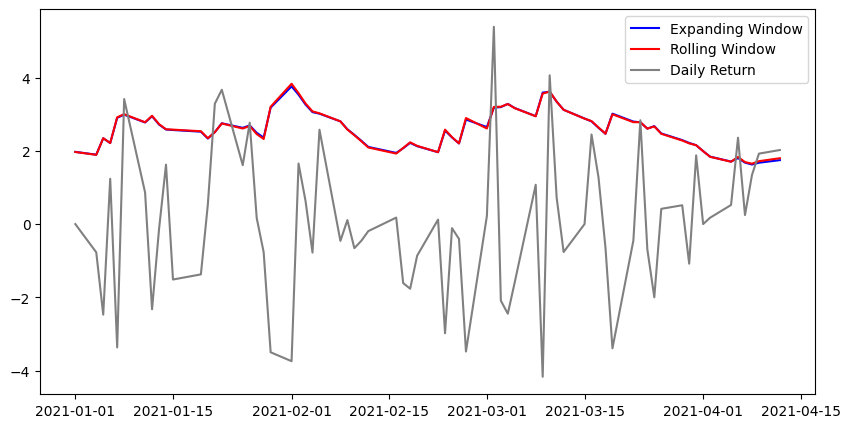

In [22]:
pred_vol_expand = np.sqrt(pred_variance_expand)

pred_vol_fixedwin = np.sqrt(pred_variance_fixed)

plt.figure(figsize=(10,5))
plt.plot(pred_vol_expand, color = 'blue', label='Expanding Window')
plt.plot(pred_vol_fixedwin, color = 'red', label='Rolling Window')
plt.plot(datos_cartera['rent_apple'].loc[pred_variance_expand.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

### MSFT

Text(0.5, 1.0, 'Serie Temporal de MSFT')

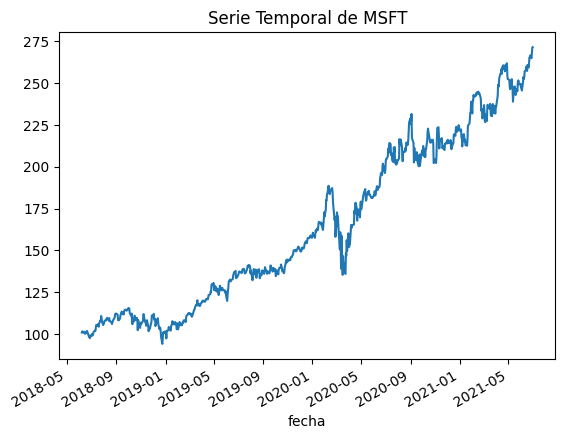

In [23]:
datos_cartera['MSFT'].plot()
plt.title('Serie Temporal de MSFT')

In [24]:
datos_cartera['MSFT'].isna().sum()

np.int64(0)

In [25]:
datos_cartera['MSFT'].resample('Y').count()

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\1920217640.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['MSFT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: MSFT, dtype: int64

ESTACIONALIDAD

Text(0.5, 1.0, 'Autocorrelación ACF de MSFT')

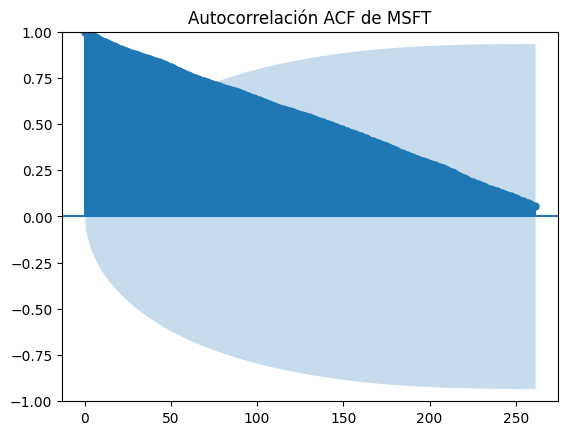

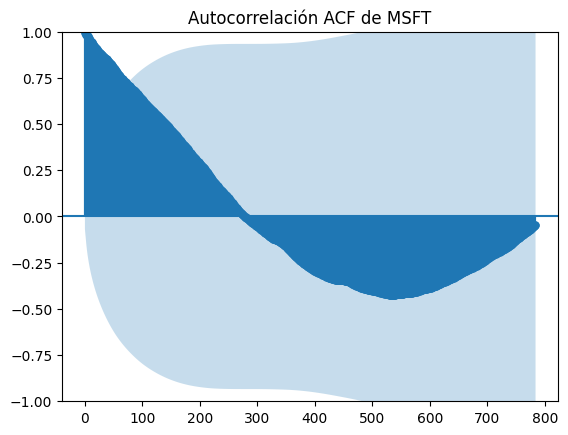

In [26]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['MSFT'], lags=261);
plt.title('Autocorrelación ACF de MSFT')
tsaplots.plot_acf(datos_cartera['MSFT'], lags=(261*3));
plt.title('Autocorrelación ACF de MSFT')

TENDENCIA

In [27]:
decomposicion_msft=seasonal_decompose(datos_cartera['MSFT'], model='multiplicative', period=261)

<Axes: xlabel='fecha'>

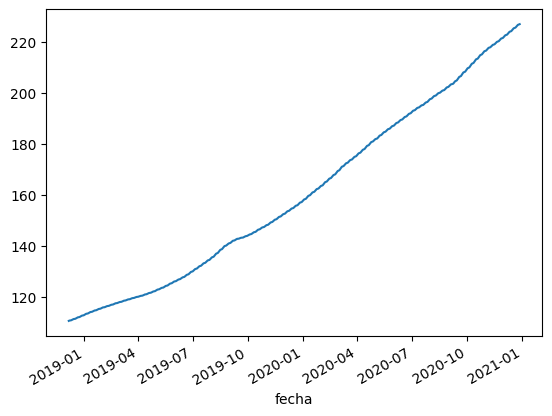

In [28]:
trend_msft=decomposicion_msft.trend
trend_msft.dropna(inplace=True)
trend_msft.plot()

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

In [29]:
datos_cartera['residuo_MSFT'] = datos_cartera['MSFT'].diff()

In [30]:
test_estacionario(datos_cartera['residuo_MSFT'])

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(7.756230692136409e-14),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.3196327917578183e-49),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

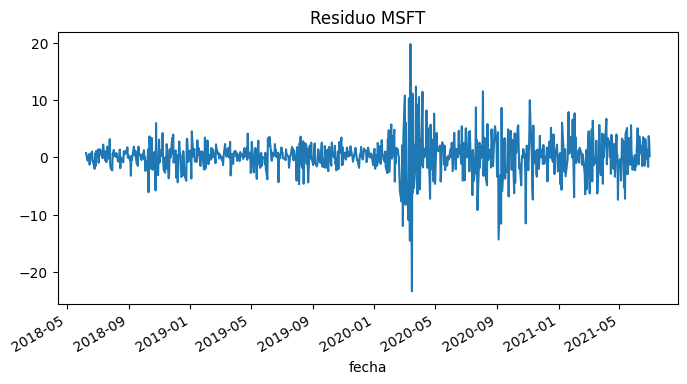

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4)) 
datos_cartera['residuo_MSFT'].plot()
plt.title("Residuo MSFT")
plt.show()


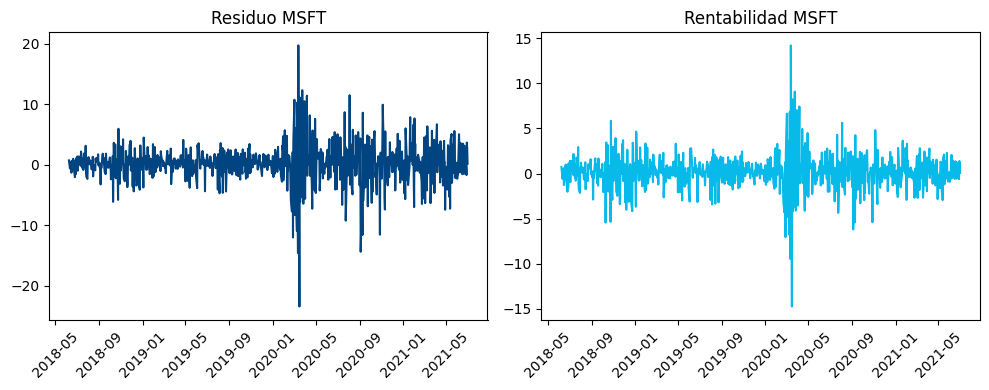

In [32]:
datos_cartera['rent_msft'] = 100*datos_cartera['MSFT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_MSFT'], color='#004481')
axes[0].set_title("Residuo MSFT")
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(datos_cartera['rent_msft'], color='#08BAE9')
axes[1].set_title("Rentabilidad MSFT")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

GARCH

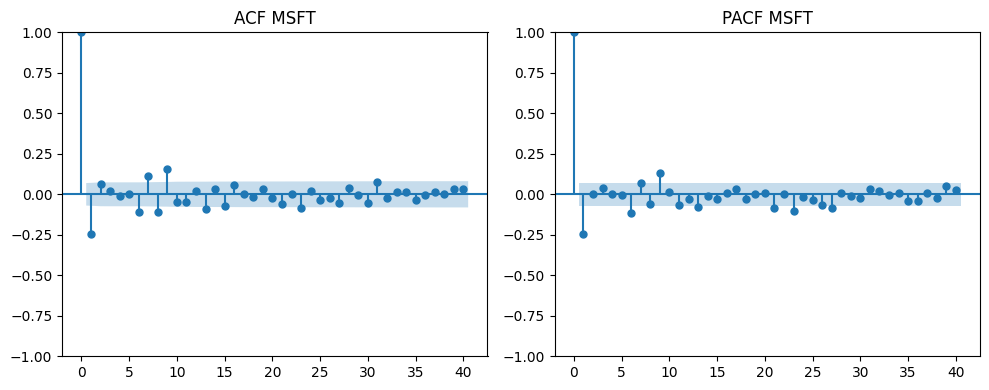

In [33]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF MSFT")

plot_pacf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF MSFT")

plt.tight_layout()
plt.show()

In [34]:
garch11 = arch_model(datos_cartera['residuo_MSFT'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_MSFT'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4027.927347653728
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6601331.582135946
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1898.291248968922
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1850.874136467246
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1864.1598836065423
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1830.698181612718
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1828.549799623553
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1893.4516568087738
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1828.4705146190315
Iteration:     10,   Func. Count:     74,   Neg. LLF: 1828.4338965681366
Iteration:     11,   Func. Count:     81,   Neg. LLF: 1828.4298350411445
Iteration:     12,   Func. Count:     87,   Neg. LLF: 1828.4298344649794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1828.4298344649794
            Iteration

In [35]:
# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)

      lb_stat  lb_pvalue
10   9.507939   0.484669
20  14.885820   0.782903
(np.float64(2.228439317349147), np.float64(0.9942705069182374), 0.22034997920074878, 0.9944448639850496)
alpha+beta = 0.96553378628348


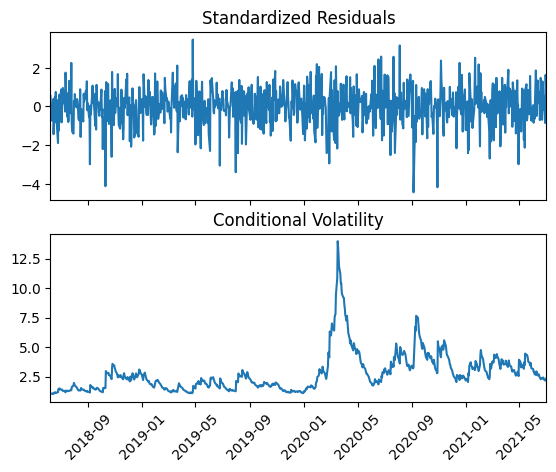

In [36]:
res11.plot()
plt.xticks(rotation=45)
plt.show()

PREDICCIÓN DE LA VOLATILIDAD

In [37]:
start_loc = 0
end_loc = np.where(datos_cartera.index >= '2021-01-01')[0].min()

print(f"Longitud del índice: {len(datos_cartera.index)}")
print(f"start_loc = {start_loc}, end_loc = {end_loc}")

Longitud del índice: 797
start_loc = 0, end_loc = 670


In [38]:
print("Tamaño total de datos:", len(datos_cartera))
print("start_loc:", start_loc)
print("end_loc:", end_loc)

Tamaño total de datos: 797
start_loc: 0
end_loc: 670


In [39]:
forecasts = {}
for i in range(70):
    res = garch11.fit( first_obs=datos_cartera.index[start_loc], last_obs=datos_cartera.index[i + end_loc], disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_expand = pd.DataFrame(forecasts).T

 Done!


In [40]:
forecasts = {}
for i in range(70):
    res = garch11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed = pd.DataFrame(forecasts).T

 Done!


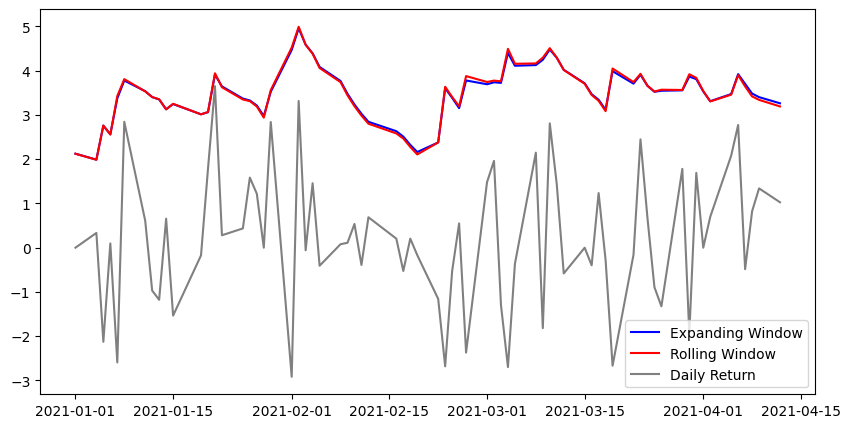

In [41]:
pred_vol_expand = np.sqrt(pred_variance_expand)

pred_vol_fixedwin = np.sqrt(pred_variance_fixed)

plt.figure(figsize=(10,5))
plt.plot(pred_vol_expand, color = 'blue', label='Expanding Window')
plt.plot(pred_vol_fixedwin, color = 'red', label='Rolling Window')
plt.plot(datos_cartera['rent_msft'].loc[pred_variance_expand.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

# CAT

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\1587260469.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['CAT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: CAT, dtype: int64

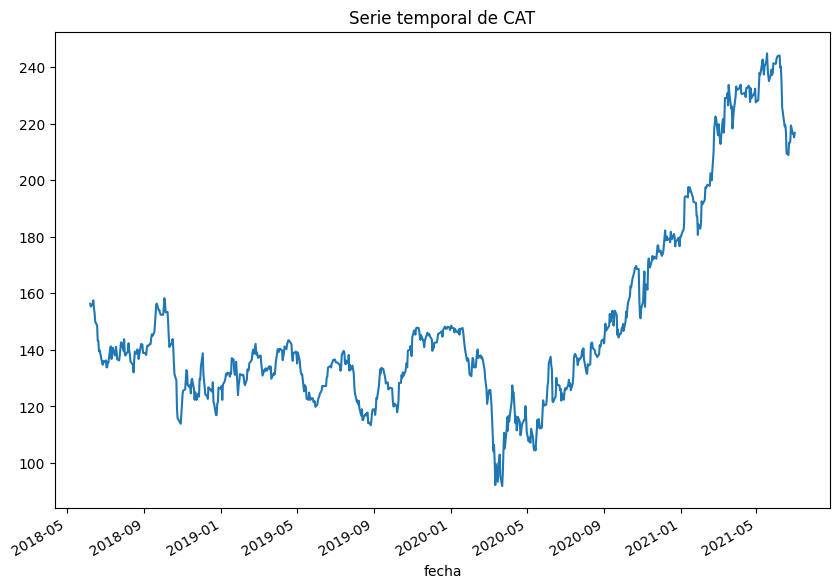

In [42]:
datos_cartera['CAT'].plot(figsize=(10,7))
plt.title('Serie temporal de CAT')
datos_cartera['CAT'].isna().sum()
datos_cartera['CAT'].dtype
datos_cartera['CAT'].resample('Y').count()

ESTACIONALIDAD

Text(0.5, 1.0, 'Autocorrelación ACF de CAT')

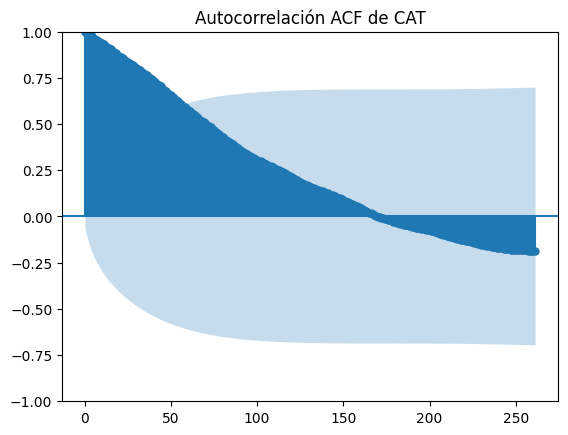

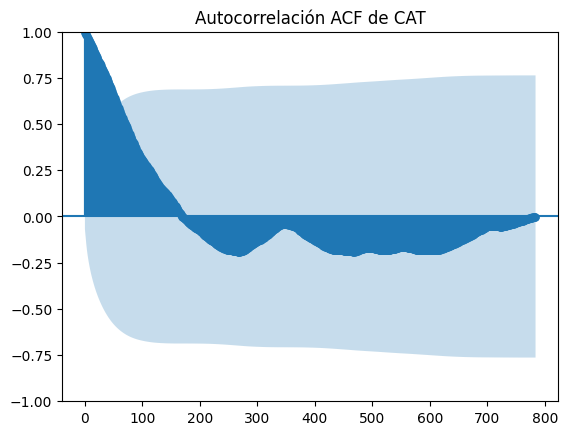

In [43]:
tsaplots.plot_acf(datos_cartera['CAT'], lags=261);
plt.title('Autocorrelación ACF de CAT')
tsaplots.plot_acf(datos_cartera['CAT'], lags=(261*3));
plt.title('Autocorrelación ACF de CAT')

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

<Axes: xlabel='fecha'>

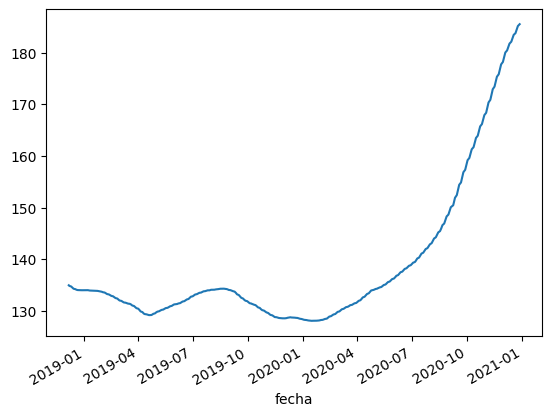

In [44]:
decomposicion_cat=seasonal_decompose(datos_cartera['CAT'], model='multiplicative', period=261)
trend_cat=decomposicion_cat.trend
trend_cat.dropna(inplace=True)
trend_cat.plot()

In [45]:
datos_cartera['residuo_CAT']=datos_cartera['CAT'].diff()

In [46]:
test_estacionario(datos_cartera['residuo_CAT'])

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(2.1009896839553222e-30),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.173071386611018e-06),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

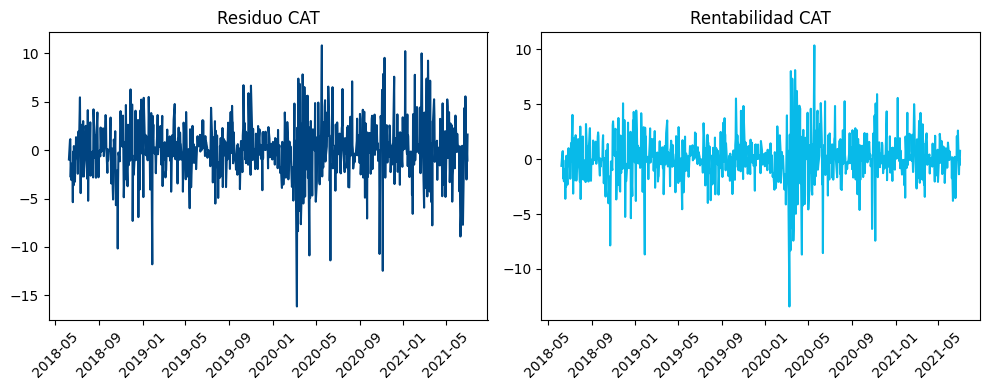

In [47]:
datos_cartera['rent_cat'] = 100*datos_cartera['CAT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_CAT'], color='#004481')
axes[0].set_title("Residuo CAT")
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(datos_cartera['rent_cat'], color='#08BAE9')
axes[1].set_title("Rentabilidad CAT")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

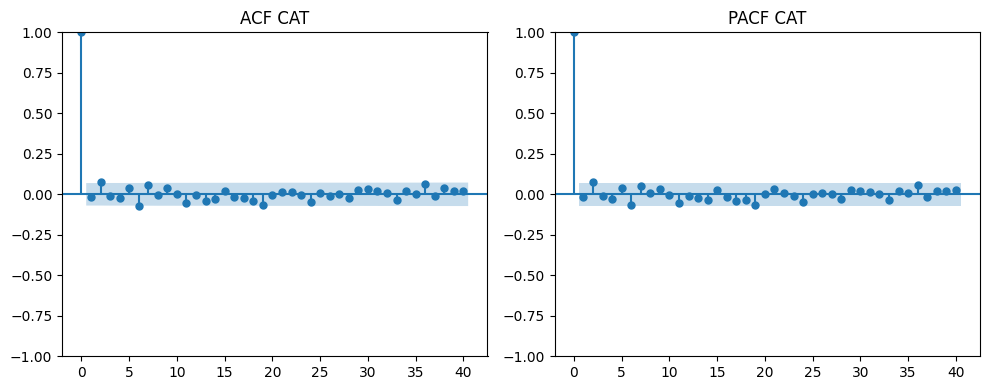

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_CAT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF CAT")

plot_pacf(datos_cartera['residuo_CAT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF CAT")

plt.tight_layout()
plt.show()

In [49]:
garch11 = arch_model(datos_cartera['residuo_CAT'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_CAT'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2290.8114889535454
Iteration:      2,   Func. Count:     17,   Neg. LLF: 922966668.8028572
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2184.637620169902
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1964.320479375597
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1972.5579595100762
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1989.0225598190098
Iteration:      7,   Func. Count:     58,   Neg. LLF: 1956.7077258532806
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1956.707780748336
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1956.70767470671
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1956.7076747081242
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1956.70767470671
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2482.590356542

In [50]:
test_estacionario(res11.std_resid)

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_8400\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(2.3562204343351157e-30),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(0.8455857644842224),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'No hay heterocedasticidad (varianza constante)'}

In [51]:
# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)

      lb_stat  lb_pvalue
10  12.874404   0.230779
20  24.376413   0.226336
(np.float64(0.6884422031411486), np.float64(0.9999697344326778), 0.06794025914137752, 0.9999709258564402)
alpha+beta = 0.9701663331204863


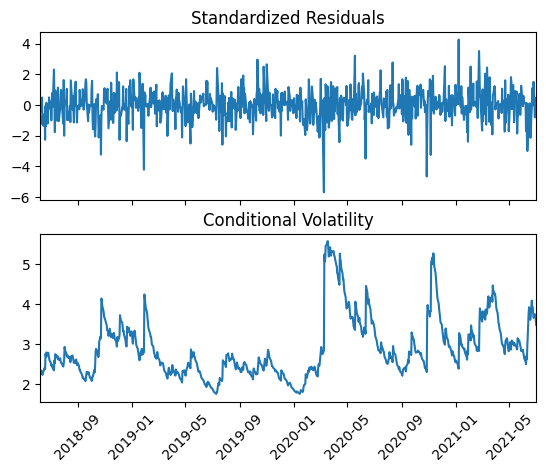

In [52]:
res11.plot()
plt.xticks(rotation=45)
plt.show()

PREDICCIÓN DE LA VOLATILIDAD

In [53]:
start_loc = 0
end_loc = np.where(datos_cartera.index >= '2021-01-01')[0].min()

print(f"Longitud del índice: {len(datos_cartera.index)}")
print(f"start_loc = {start_loc}, end_loc = {end_loc}")

Longitud del índice: 797
start_loc = 0, end_loc = 670


In [54]:
print("Tamaño total de datos:", len(datos_cartera))
print("start_loc:", start_loc)
print("end_loc:", end_loc)

Tamaño total de datos: 797
start_loc: 0
end_loc: 670


In [55]:
forecasts = {}
for i in range(70):
    res = garch11.fit( first_obs=datos_cartera.index[start_loc], last_obs=datos_cartera.index[i + end_loc], disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_expand = pd.DataFrame(forecasts).T

 Done!


In [56]:
forecasts = {}
for i in range(70):
    res = garch11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed = pd.DataFrame(forecasts).T

 Done!


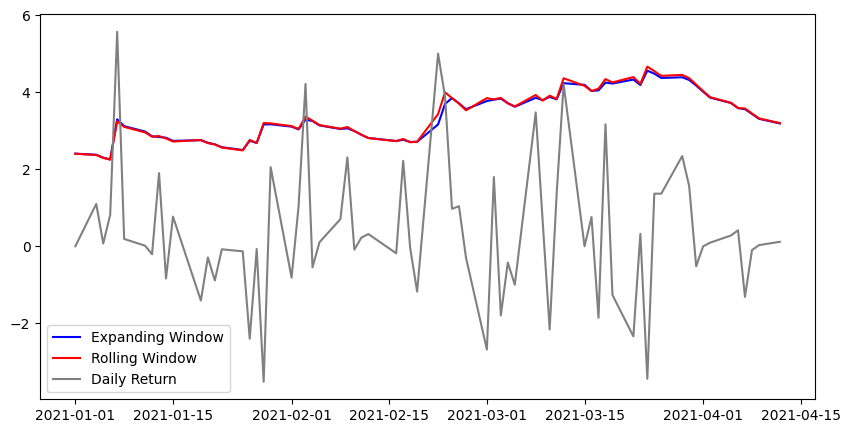

In [57]:
pred_vol_expand = np.sqrt(pred_variance_expand)

pred_vol_fixedwin = np.sqrt(pred_variance_fixed)

plt.figure(figsize=(10,5))
plt.plot(pred_vol_expand, color = 'blue', label='Expanding Window')
plt.plot(pred_vol_fixedwin, color = 'red', label='Rolling Window')
plt.plot(datos_cartera['rent_cat'].loc[pred_variance_expand.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()